In [ ]:
import pulp
import numpy as np
import pandas as pd
from sklearn import  *
import random
import time
import matplotlib.pyplot as plt
from  sklearn.model_selection import train_test_split





start_time = time.time()


df = pd.read_excel('regdata1500.xlsx',header=None)



x = df.iloc[:,:3].values
y =  np.reshape(df.iloc[:,3:].values,(1,len(df.iloc[:,3:].values)))[0]

# data normalization
scaler = preprocessing.StandardScaler().fit(x)
x = scaler.transform(x)
# x_test_matrix = scaler.transform(y)              # wrongly_scaled = preprocessing.scale(x_test_matrix)

x_train_matrix , x_test_matrix , y_train_list , y_test_list =  train_test_split( x , y , random_state= 33 ,test_size= 0.4)




# x_train_matrix , x_test_matrix , y_train_list , y_test_list =  train_test_split(x_train_matrix, y_train_list , random_state= 33 ,test_size= 0.4)

# x_train_matrix , x_test_matrix = [x_train_matrix [adx :: 5] for adx in range(2)]
# y_train_list , y_test_list = [y_train_list [adx :: 5] for adx in range(2)]



# data normalization
# scaler = preprocessing.StandardScaler().fit(x_train_matrix)
# x_train_matrix = scaler.transform(x_train_matrix)
# x_test_matrix = scaler.transform(x_test_matrix)              # wrongly_scaled = preprocessing.scale(x_test_matrix)




#    outputs Gi's  in a 1D array     (Normalized)
def g_normalized_list (test_sample_list , train_data_designMX , y_train_list , standard_deviation ) :
    g_unormalized = []
    g_normalized = []
    g_normalized_multiplied_by_real_y = []
    for sample in range (len(train_data_designMX)) :
        similarity = 1
        for feature in range (len(train_data_designMX[sample])) :
            similarity *= np.exp(- ((train_data_designMX[sample][feature] - test_sample_list [feature]) **2 ) / standard_deviation)

        g_unormalized.append(similarity)
    for i in range (len(g_unormalized)) :

        if sum(g_unormalized) == 0:
            aaaaa = 0.00001
        else:
            aaaaa = sum(g_unormalized)
        g_normalized.append(g_unormalized[i] / aaaaa)

    for i in range (len(g_normalized)) :
        g_normalized_multiplied_by_real_y.append( g_normalized [i] * y_train_list [i] )

    return g_normalized




#------------------------------------------------------------------------------
""" Linear Programing Optimization for regression """
#------------------------------------------------------------------------------

#    REGULARIZATION terms
regularization_term =  1/10
std = 1


# Linear Programing model
model = pulp.LpProblem('Fuzzy Neural Network Optimization' , pulp.LpMinimize)


# variables
variables_v_list = []
variables_eps_list = []
variables_t_for_v_list = []
variables_p_for_eps_list = []


#                            Variable V
for i in range (len(x_train_matrix)+1) :
    variable_v = pulp.LpVariable(str('v'+str(i)))
    variable_t_for_v = pulp.LpVariable(str('t' + str(i)))
    variables_v_list.append(variable_v)
    variables_t_for_v_list.append(variable_t_for_v)
#                            Varibale Epsilon
for i in range (len(x_train_matrix)) :
    variable_epsilon = pulp.LpVariable(str('eps' + str(i+1)))
    variable_p_for_eps = pulp.LpVariable(str('p' + str(i+1)))
    variables_eps_list.append(variable_epsilon)
    variables_p_for_eps_list.append(variable_p_for_eps)




# objective function preproccess
soosk = ''
for i in range (len(variables_t_for_v_list)):
    soosk += variables_t_for_v_list [i]
soosk1 = ''
for i in range (len(variables_p_for_eps_list)):
    soosk1 += variables_p_for_eps_list[i]


# The OBJECTIVE FUNCTION
model += soosk + soosk1 , 'Last Layer weights'



# CONSTRAINS-----------------------------------

#                   INEQUALITIES
for i in range (len(variables_t_for_v_list)) :
    model += ( variables_t_for_v_list[i] ) >= (variables_v_list [i] * regularization_term)
    model += (variables_t_for_v_list[i]) >= - (variables_v_list[i] * regularization_term)

for i in range (len(variables_p_for_eps_list)) :
    model += variables_p_for_eps_list [i] >= variables_eps_list [i]
    model += variables_p_for_eps_list[i] >=  - ( variables_eps_list[i]  )


#                     EQUALITIES
for j in range (len(variables_eps_list)):
    list_temp = g_normalized_list(x_train_matrix[j], x_train_matrix, y_train_list, std)
    summ = variables_v_list [0] 

    for i in range (1,len(variables_eps_list)+1) :
        summ += variables_v_list[i] *list_temp[i-1]

    model += variables_eps_list[j] == summ - y_train_list[j]



end_time = time.time()



print('elapsed time = ',end_time-start_time)


elapsed time =  129.7166314125061


In [ ]:

start_time = time.time()

# Solving the problem
results = model.solve()

end_time = time.time()


# print solving status
print('Status :', pulp.LpStatus[model.status],'\n\n')



# Extracting V values  to a final list called V_list
v_list = []
temp_v_list = []
temp_v_list1 = []
for i in model.variables():
    # if 'v' in i.name :                                     # print variable values
        # print(i.name,'=',i.varValue)                       # print variable values

    if 'v' in i.name :
        temp_v_list.append((i.name, i.varValue))
for i in range (len(temp_v_list)):
    i,j = temp_v_list [i]
    i = i.replace('v','')
    temp_v_list1.append((int(i), j))
sorted_list = sorted (temp_v_list1, key= lambda tup : (tup[0]))
for i in range (len(sorted_list)) :
    i,j = sorted_list [i]
    v_list.append(j)




# Report Number f rules --------------
county = 0
for i in range (len(v_list)):
    if v_list[i] == 0 :
        county += 1
print('Total Number of Possible Rules (including V0) =',len(v_list))
print('\nTotal Number Of Deactivated Rules  (Vi = 0) =',county)
print('\nTotal Number Of Active Rules =',len(v_list)-county)
print('\nTime Elapsed at Optimization Solver =',end_time-start_time,'seconds')





#-------------------------------------------------------------------------------------------



# -----  Prediction of Binary Classification (-1,1) Based On Training Set And Gived Vi's   ------
def predict_Binary_Classification  (test_sample_list , train_data_designMX   , v_values ,  standard_deviation) :
    
    g_unormalized = []
    g_normalized = []

    for sample in range (len(train_data_designMX)) :
        similarity = 1
        for feature in range (len(train_data_designMX[sample])) :
            similarity *= np.exp(- ((train_data_designMX[sample][feature] - test_sample_list [feature]) **2 ) / standard_deviation)
        g_unormalized.append(similarity)
    for i in range (len(g_unormalized)) :

        if sum(g_unormalized) == 0 :
            aaaaa = 0.0000001
        else:aaaaa = sum(g_unormalized)
        
        g_normalized.append(g_unormalized[i]/aaaaa)

 

    maaa_v = v_values.copy()
    v0 = maaa_v.pop(0)
    predict = 0
    for i in range (len(g_normalized)) :
        predict += (g_normalized[i] * maaa_v[i])
        # print('ssss =',(g_unormalized[i] ))
        # print('pppp =',g_normalized_multiplied_by_real_y[i])
        # print(i)
    predict += v0               #    * (sum(g_normalized_multiplied_by_real_y)/len(g_normalized_multiplied_by_real_y))


    # for i in range (len(g_normalized)) :
    #     g_normalized_multiplied_by_real_y.append( g_normalized [i] * y_of_train_list [i] )


    return predict




Status : Optimal 




Total Number of Possible Rules (including V0) = 901

Total Number Of Deactivated Rules  (Vi = 0) = 838

Total Number Of Active Rules = 63

Time Elapsed at Optimization Solver = 46.579164266586304 seconds


In [ ]:
start_time = time.time()
yyyy_list_train = []
yyyy_list_test = []

accuracy_train = 0
for i in range (len(x)) :
    yyyy = predict_Binary_Classification(x[i],x_train_matrix  , v_list , std )
    yyyy_list_train.append(yyyy)
    accuracy_train +=  abs(( yyyy -y[i]))
print('\n\n MAE of train = ', (accuracy_train/len(x_train_matrix)) )


# accuracy_test = 0
# for i in range (len(x_test_matrix)) :
#     # print(predict_Binary_Classification(x_test_matrix[i], x_train_matrix ,y_train_list, v_list , std ) [0])
#     yyyy =predict_Binary_Classification(x_test_matrix[i], x_train_matrix, v_list, std)
#     yyyy_list_test.append(yyyy)
#     accuracy_test  += abs(yyyy - y_test_list[i])
# 
# print(' MAE of  test = ',accuracy_test/len(x_test_matrix))
# end_time = time.time()
# print('elapsed time = ',end_time-start_time)



 MAE of train =  8.039416555470664


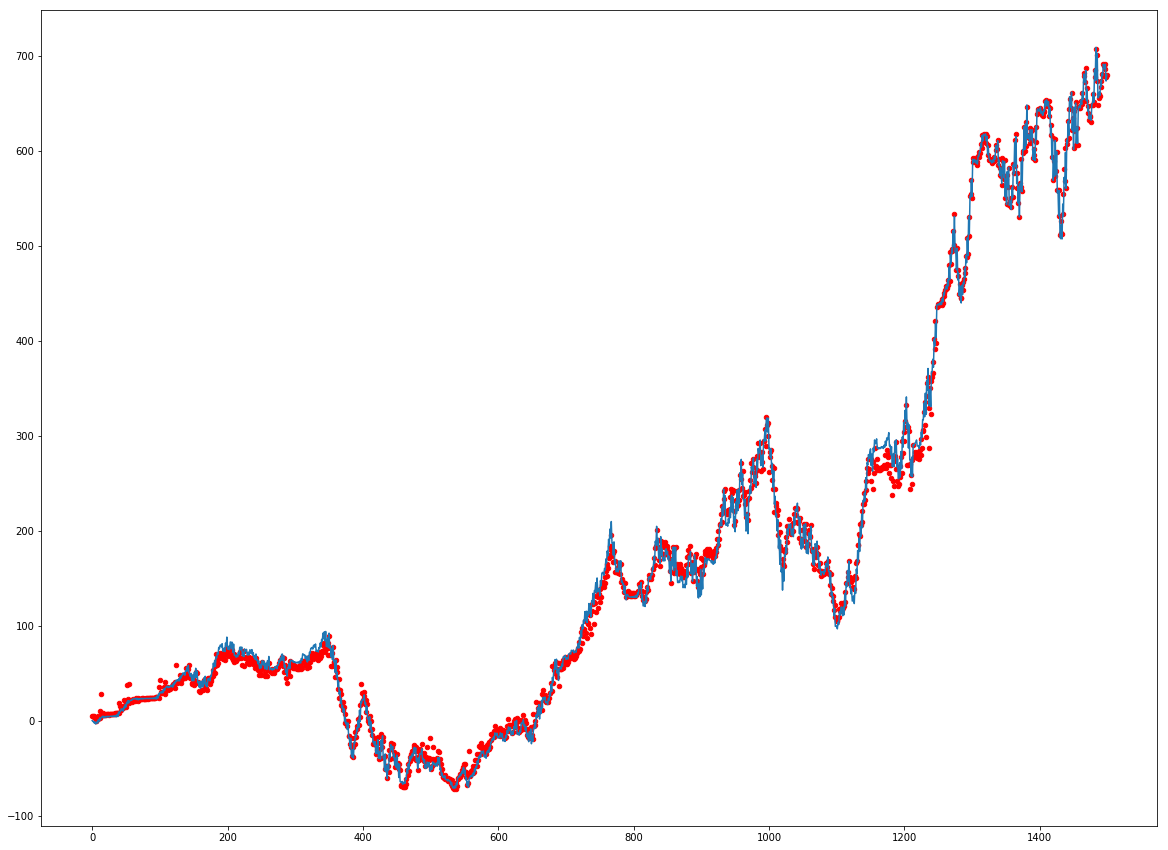

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 20 , 15

plt.scatter(np.arange(len(yyyy_list_train)),yyyy_list_train , s = 20,color = 'r')

plt.plot(np.arange(len(y)), y)



